1. Data Preparation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_excel(r'C:\Users\Admin\Documents\EXCELR\DS Assignments\@\heart_disease.xlsx', sheet_name='Heart_disease')

# Check initial structure
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)

Dataset shape: (908, 13)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'thal', 'num']

First 5 rows:
   age   sex               cp  trestbps  chol    fbs         restecg  thalch  \
0   63  Male   typical angina       145   233   True  lv hypertrophy     150   
1   41  Male  atypical angina       135   203  False          normal     132   
2   57  Male     asymptomatic       140   192  False          normal     148   
3   52  Male   typical angina       118   186  False  lv hypertrophy     190   
4   57  Male     asymptomatic       110   201  False          normal     126   

   exang  oldpeak        slope          thal  num  
0  False      2.3  downsloping  fixed defect    0  
1  False      0.0         flat  fixed defect    0  
2  False      0.4         flat  fixed defect    0  
3  False      0.0         flat  fixed defect    0  
4   True      1.5         flat  fixed defect    0  

Data types:
age           int64
sex         

2. Exploratory Data Analysis (EDA)

Missing values in each column:
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalch       0
exang        0
oldpeak     62
slope        0
thal         0
num          0
dtype: int64

sex unique values: ['Male' 'Female']
Counts:
sex
Male      718
Female    190
Name: count, dtype: int64

cp unique values: ['typical angina' 'atypical angina' 'asymptomatic' 'non-anginal']
Counts:
cp
asymptomatic       495
non-anginal        203
atypical angina    165
typical angina      45
Name: count, dtype: int64

restecg unique values: ['lv hypertrophy' 'normal' 'st-t abnormality']
Counts:
restecg
normal              542
lv hypertrophy      187
st-t abnormality    179
Name: count, dtype: int64

exang unique values: [False True 'FALSE' 'TURE']
Counts:
exang
False    516
True     337
TURE      36
FALSE     19
Name: count, dtype: int64

slope unique values: ['downsloping' 'flat' 'upsloping']
Counts:
slope
flat           453
upsloping      298
downslo

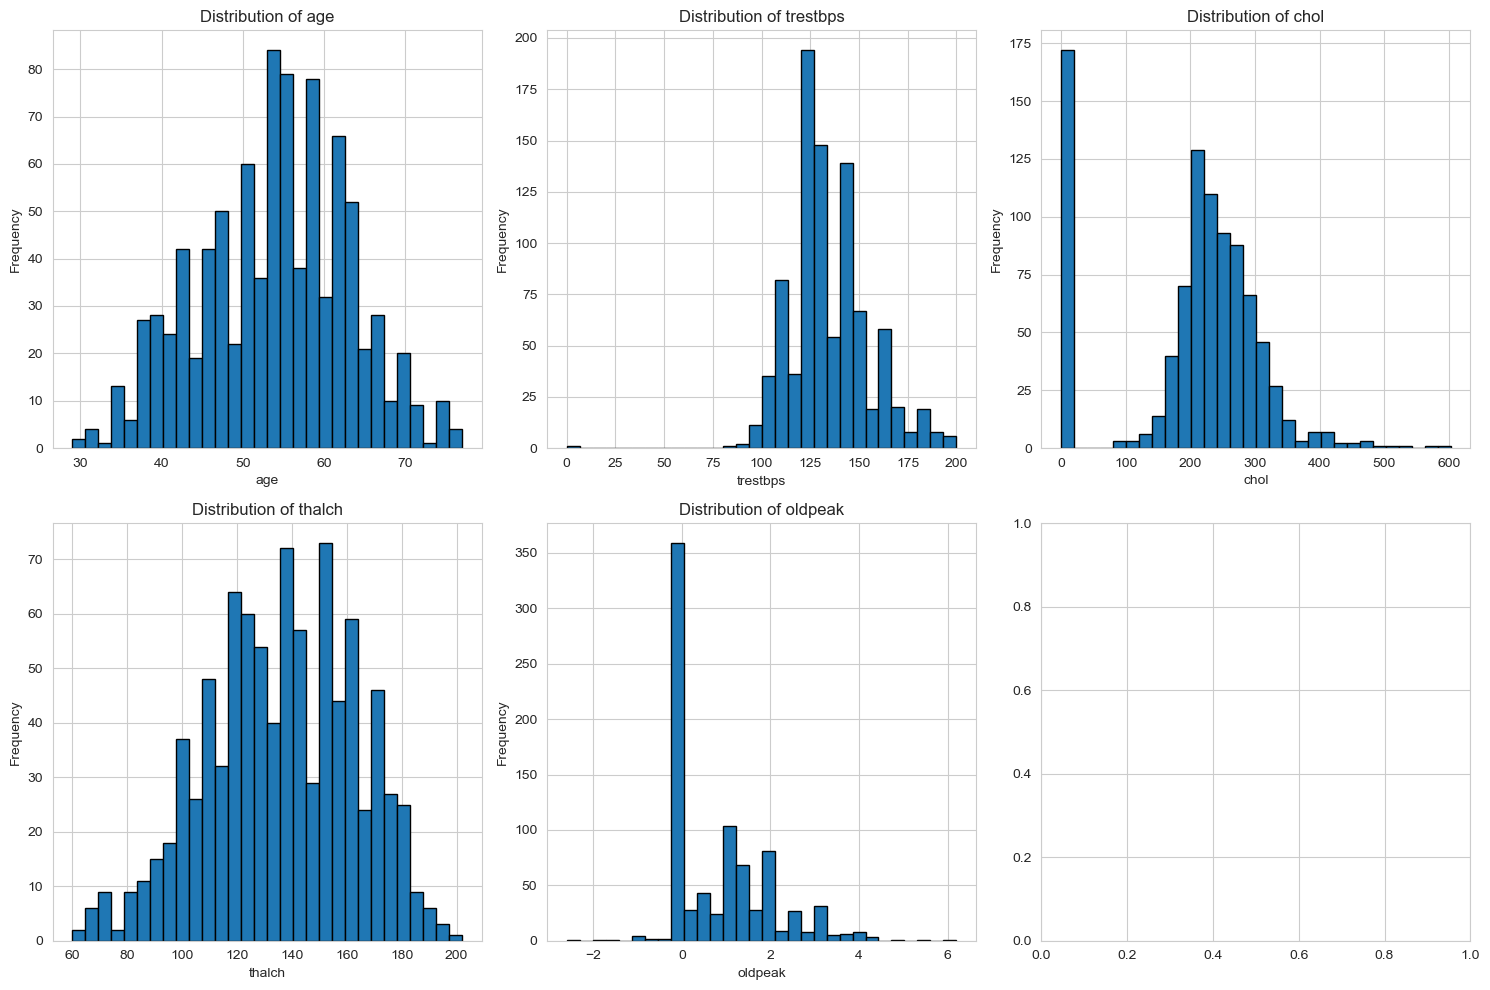

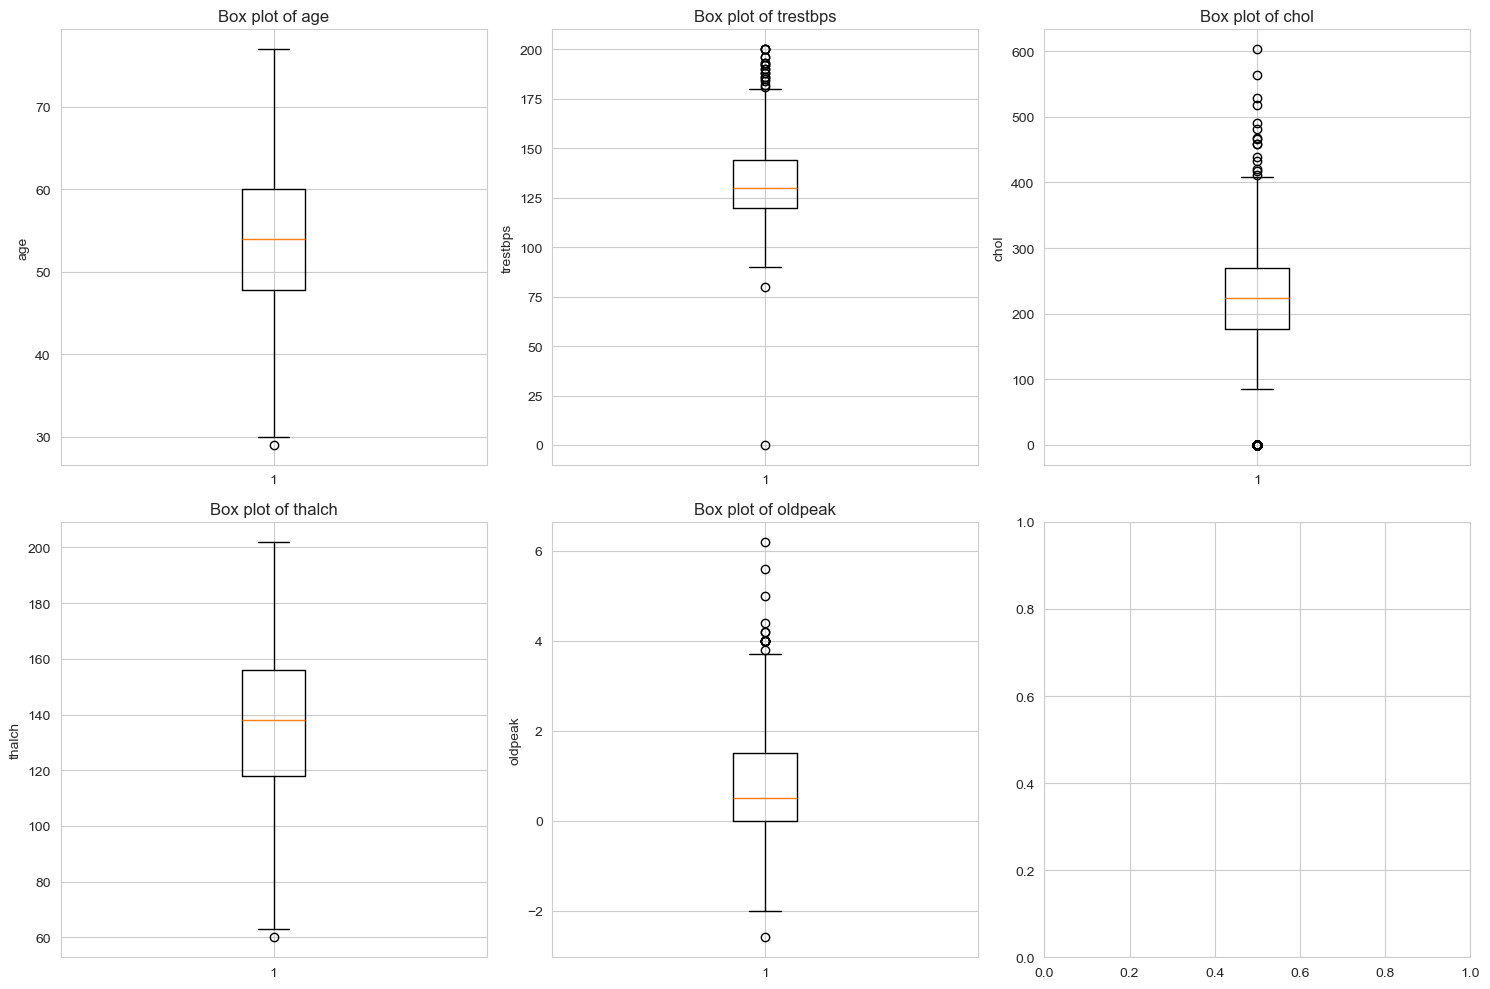

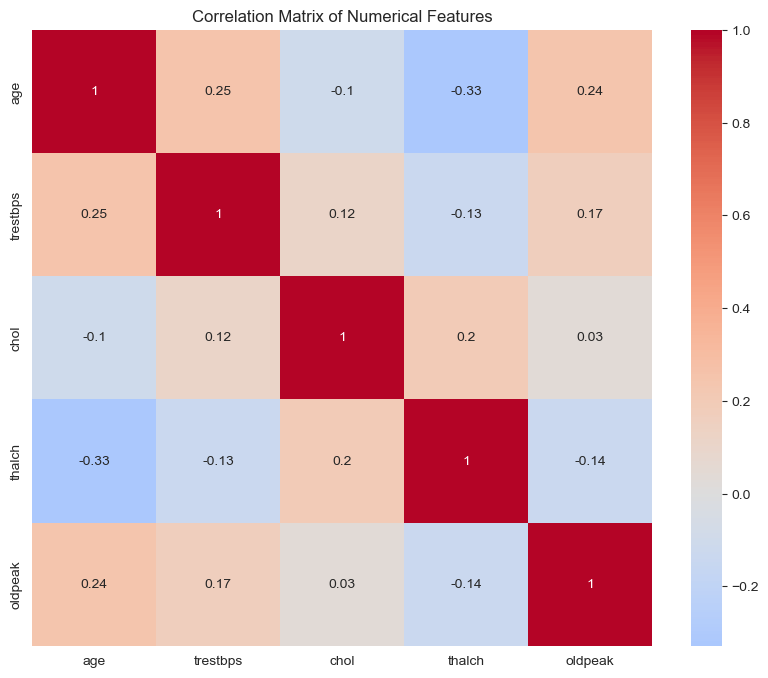

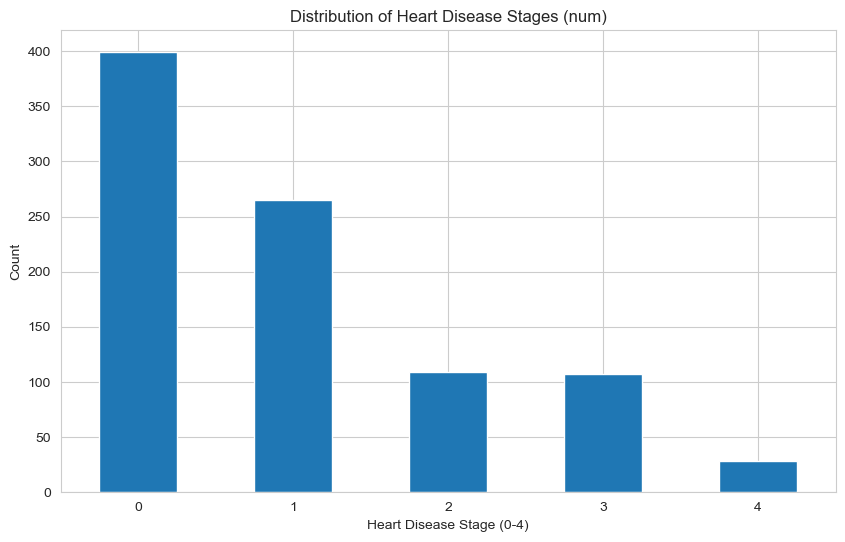


Binary target distribution:
heart_disease_binary
1    509
0    399
Name: count, dtype: int64
Percentage: heart_disease_binary
1    56.057269
0    43.942731
Name: proportion, dtype: float64


In [6]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Check unique values for categorical columns
categorical_cols = ['sex', 'cp', 'restecg', 'exang', 'slope', 'thal']
for col in categorical_cols:
    print(f"\n{col} unique values: {df[col].unique()}")
    print(f"Counts:\n{df[col].value_counts()}")

# Check target variable distribution
print(f"\nTarget variable (num) distribution:")
print(df['num'].value_counts())
print(f"Percentage:\n{df['num'].value_counts(normalize=True) * 100}")

# Check for zeros in numerical columns that shouldn't be zero
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
for col in numerical_cols:
    zero_count = (df[col] == 0).sum()
    if zero_count > 0:
        print(f"{col} has {zero_count} zero values ({zero_count/len(df)*100:.2f}%)")

# Visualize numerical features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols[:6]):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Box plots for outlier detection
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols[:6]):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(f'Box plot of {col}')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Target distribution
plt.figure(figsize=(10, 6))
df['num'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Heart Disease Stages (num)')
plt.xlabel('Heart Disease Stage (0-4)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Convert target to binary for initial analysis (0 vs 1-4)
df['heart_disease_binary'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
print(f"\nBinary target distribution:")
print(df['heart_disease_binary'].value_counts())
print(f"Percentage: {df['heart_disease_binary'].value_counts(normalize=True) * 100}")

3. Feature Engineering

In [7]:
# Create a copy for preprocessing
df_clean = df.copy()

# Handle missing values
print("Missing values before handling:")
print(df_clean.isnull().sum())

# Fill missing values in oldpeak with median
df_clean['oldpeak'] = df_clean['oldpeak'].fillna(df_clean['oldpeak'].median())

# Handle zeros in numerical columns (replace with median)
for col in ['trestbps', 'chol', 'thalch']:
    median_val = df_clean[df_clean[col] > 0][col].median()
    df_clean[col] = df_clean[col].replace(0, median_val)

# Convert categorical variables
# Sex: Male=1, Female=0
df_clean['sex'] = df_clean['sex'].map({'Male': 1, 'Female': 0})

# Handle categorical variables with LabelEncoder for tree-based models
le = LabelEncoder()
categorical_to_encode = ['cp', 'restecg', 'slope', 'thal']

for col in categorical_to_encode:
    # Handle the Excel formula strings
    mask = df_clean[col].astype(str).str.startswith('=CHOOSE')
    df_clean.loc[mask, col] = 'normal'  # Replace formula with default value
    
    # Clean any string inconsistencies
    df_clean[col] = df_clean[col].astype(str).str.lower().str.strip()
    
    # Use LabelEncoder
    df_clean[col] = le.fit_transform(df_clean[col])

# Exang: Convert to binary
df_clean['exang'] = df_clean['exang'].map({True: 1, False: 0, 'TRUE': 1, 'FALSE': 0, 'TURE': 1})
df_clean['exang'] = pd.to_numeric(df_clean['exang'], errors='coerce').fillna(0).astype(int)

# Fbs: Convert to binary
df_clean['fbs'] = df_clean['fbs'].map({True: 1, False: 0, 'TRUE': 1, 'FALSE': 0})
df_clean['fbs'] = pd.to_numeric(df_clean['fbs'], errors='coerce').fillna(0).astype(int)

print("\nMissing values after handling:")
print(df_clean.isnull().sum())

# Define features and target
X = df_clean.drop(['num', 'heart_disease_binary'], axis=1)
y_binary = df_clean['heart_disease_binary']  # Binary classification
y_multiclass = df_clean['num']  # Multiclass classification

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape (binary): {y_binary.shape}")
print(f"Target shape (multiclass): {y_multiclass.shape}")

Missing values before handling:
age                      0
sex                      0
cp                       0
trestbps                 0
chol                     0
fbs                      0
restecg                  0
thalch                   0
exang                    0
oldpeak                 62
slope                    0
thal                     0
num                      0
heart_disease_binary     0
dtype: int64

Missing values after handling:
age                     0
sex                     0
cp                      0
trestbps                0
chol                    0
fbs                     0
restecg                 0
thalch                  0
exang                   0
oldpeak                 0
slope                   0
thal                    0
num                     0
heart_disease_binary    0
dtype: int64

Feature matrix shape: (908, 12)
Target shape (binary): (908,)
Target shape (multiclass): (908,)


4. Decision Tree Classification

4.1 Binary Classification (Disease vs No Disease)

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

# Initial Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\n=== Binary Classification Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Disease', 'Disease']))

Training set size: (726, 12)
Test set size: (182, 12)
Training target distribution:
heart_disease_binary
1    0.560606
0    0.439394
Name: proportion, dtype: float64
Test target distribution:
heart_disease_binary
1    0.56044
0    0.43956
Name: proportion, dtype: float64

=== Binary Classification Results ===
Accuracy: 0.7253
Precision: 0.7549
Recall: 0.7549
F1-Score: 0.7549
ROC-AUC: 0.7212

Confusion Matrix:
[[55 25]
 [25 77]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.69      0.69      0.69        80
     Disease       0.75      0.75      0.75       102

    accuracy                           0.73       182
   macro avg       0.72      0.72      0.72       182
weighted avg       0.73      0.73      0.73       182



4.2 Multiclass Classification (Disease Stages 0-4)

In [9]:
# Split for multiclass
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

# Multiclass Decision Tree
dt_model_multi = DecisionTreeClassifier(random_state=42)
dt_model_multi.fit(X_train_multi, y_train_multi)

# Predictions
y_pred_multi = dt_model_multi.predict(X_test_multi)

# Evaluation metrics for multiclass
print("\n=== Multiclass Classification Results ===")
print(f"Accuracy: {accuracy_score(y_test_multi, y_pred_multi):.4f}")
print(f"Macro Precision: {precision_score(y_test_multi, y_pred_multi, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test_multi, y_pred_multi, average='macro'):.4f}")
print(f"Macro F1-Score: {f1_score(y_test_multi, y_pred_multi, average='macro'):.4f}")

print("\nClassification Report (Multiclass):")
print(classification_report(y_test_multi, y_pred_multi))


=== Multiclass Classification Results ===
Accuracy: 0.5275
Macro Precision: 0.3801
Macro Recall: 0.3746
Macro F1-Score: 0.3750

Classification Report (Multiclass):
              precision    recall  f1-score   support

           0       0.73      0.72      0.73        80
           1       0.49      0.51      0.50        53
           2       0.11      0.09      0.10        22
           3       0.32      0.38      0.35        21
           4       0.25      0.17      0.20         6

    accuracy                           0.53       182
   macro avg       0.38      0.37      0.37       182
weighted avg       0.52      0.53      0.52       182



5. Hyperparameter Tuning

In [10]:
# Hyperparameter tuning for binary classification
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train with best parameters
best_dt_model = grid_search.best_estimator_
best_dt_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_best = best_dt_model.predict(X_test)
y_pred_proba_best = best_dt_model.predict_proba(X_test)[:, 1]

print("\n=== Tuned Model Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")

Fitting 5 folds for each of 672 candidates, totalling 3360 fits
Best parameters found:
{'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20}
Best cross-validation score: 0.7988

=== Tuned Model Results ===
Accuracy: 0.7088
Precision: 0.7379
Recall: 0.7451
F1-Score: 0.7415
ROC-AUC: 0.7592


6. Model Evaluation and Analysis

Top 10 Feature Importances:
     feature  importance
8      exang    0.348073
2         cp    0.142262
7     thalch    0.136946
9    oldpeak    0.075643
1        sex    0.068463
0        age    0.059846
4       chol    0.055563
10     slope    0.043111
3   trestbps    0.042670
5        fbs    0.016953


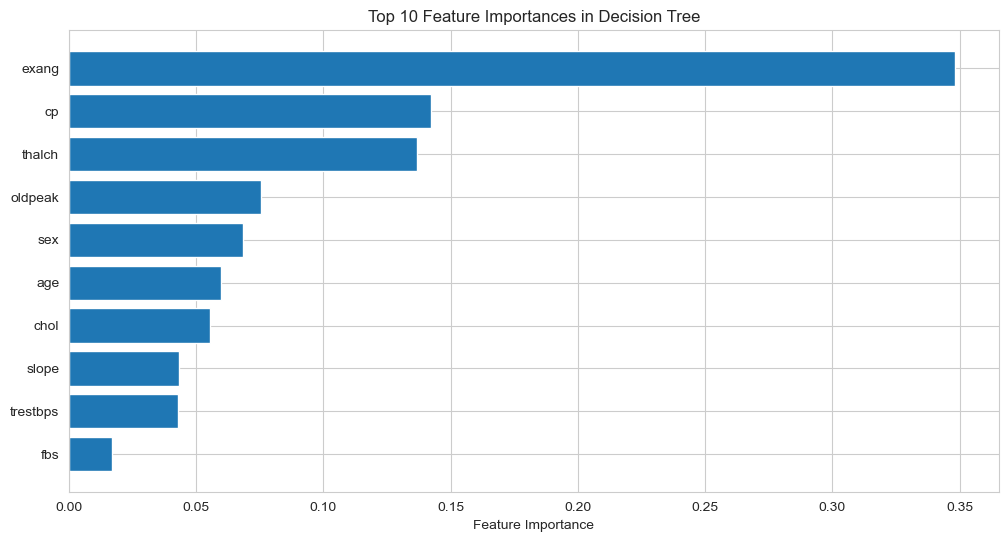

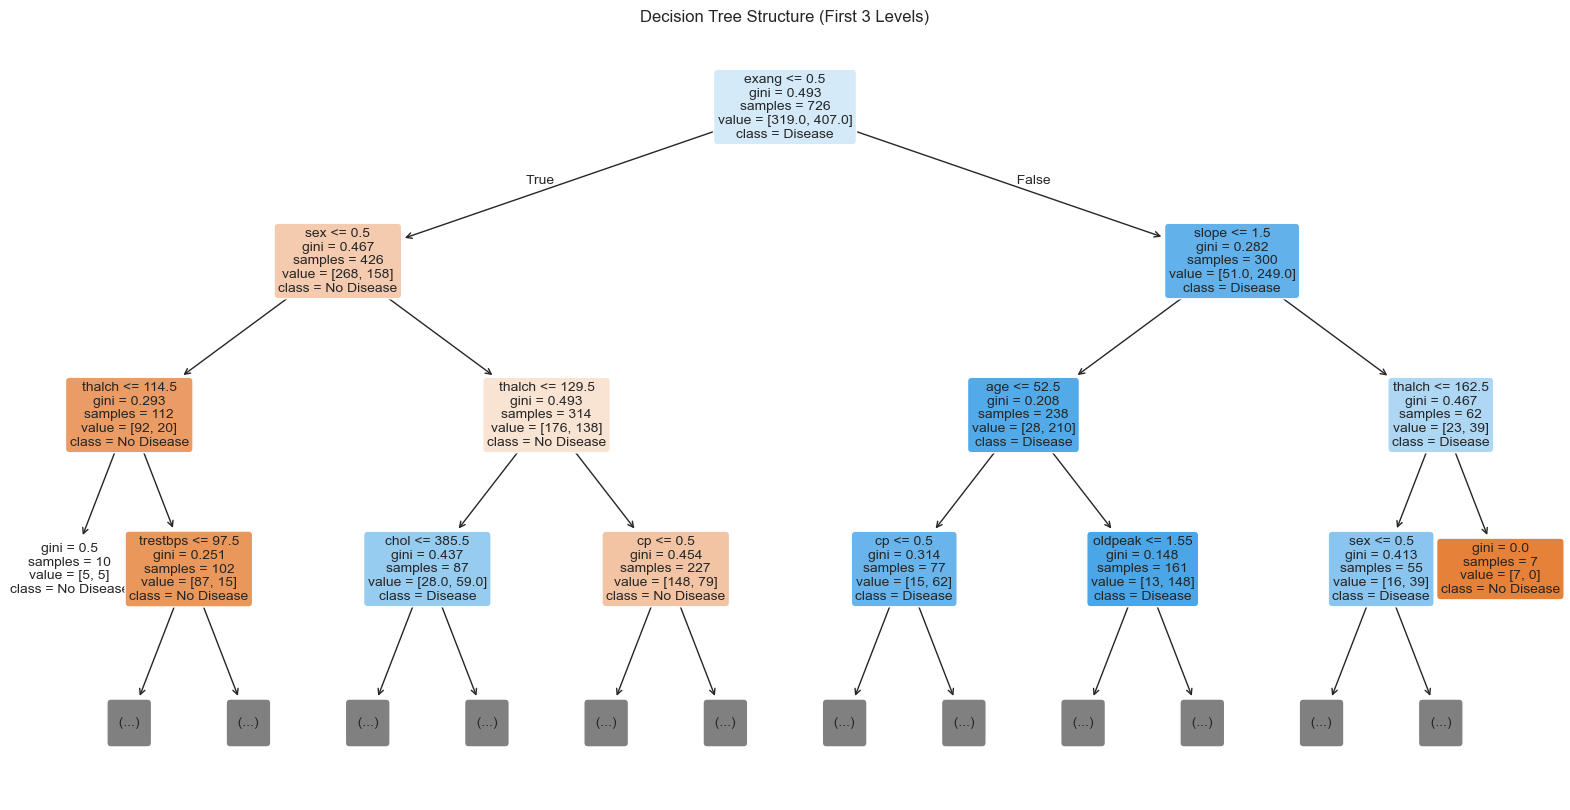


Training Accuracy: 0.8526
Testing Accuracy: 0.7088
Difference: 0.1438


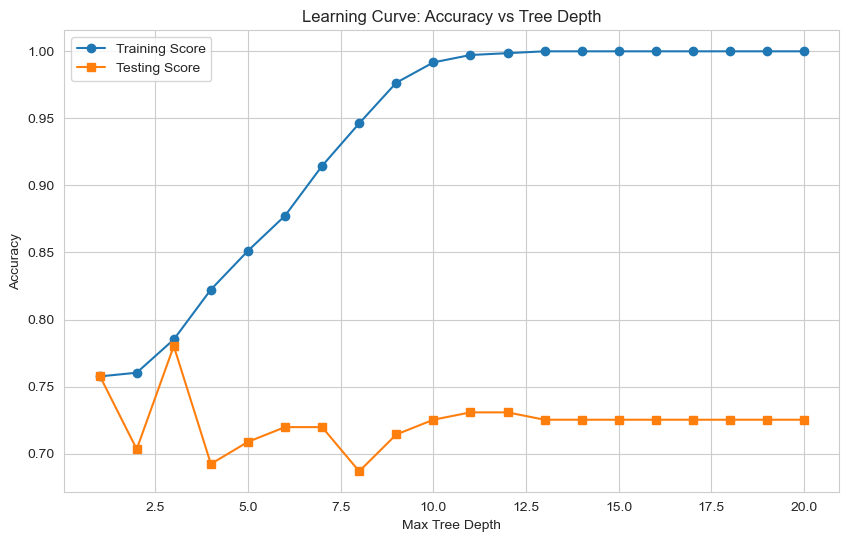

In [11]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Feature Importances:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances in Decision Tree')
plt.gca().invert_yaxis()
plt.show()

# Visualize the decision tree (pruned version for readability)
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model,
    feature_names=X.columns,
    class_names=['No Disease', 'Disease'],
    filled=True,
    rounded=True,
    max_depth=3,  # Limit depth for readability
    fontsize=10
)
plt.title('Decision Tree Structure (First 3 Levels)')
plt.show()

# Compare train vs test performance
train_score = best_dt_model.score(X_train, y_train)
test_score = best_dt_model.score(X_test, y_test)
print(f"\nTraining Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")
print(f"Difference: {abs(train_score - test_score):.4f}")

# Learning curve analysis (simplified)
max_depths = range(1, 21)
train_scores = []
test_scores = []

for depth in max_depths:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp.fit(X_train, y_train)
    train_scores.append(dt_temp.score(X_train, y_train))
    test_scores.append(dt_temp.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, label='Training Score', marker='o')
plt.plot(max_depths, test_scores, label='Testing Score', marker='s')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Accuracy vs Tree Depth')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
print('''Interview Questions
1. What are some common hyperparameters of decision tree models, and how do they affect the model's performance?
Common Hyperparameters:

max_depth: Maximum depth of the tree

Effect: Controls tree complexity. Too shallow → underfitting, too deep → overfitting

Trade-off: Balance between bias and variance

min_samples_split: Minimum samples required to split a node

Effect: Prevents splitting nodes with too few samples

Higher values: Simpler trees, less prone to overfitting

min_samples_leaf: Minimum samples required in a leaf node

Effect: Controls leaf node size

Higher values: Smoother predictions, less variance

criterion: Splitting criterion ('gini' or 'entropy')

Gini: Measures impurity, computationally faster

Entropy: Information gain, may produce slightly different splits

max_features: Number of features to consider for best split

Effect: Introduces randomness, can reduce overfitting

Common values: 'sqrt', 'log2', or None (all features)

min_impurity_decrease: Minimum impurity decrease required for split

Effect: Prevents splits that don't improve purity significantly

Performance Impact:

Underfitting: Occurs with too restrictive parameters (shallow trees, high min_samples)

Overfitting: Occurs with too permissive parameters (deep trees, low min_samples)

Optimal tuning: Requires validation (cross-validation) to find balance

2. What is the difference between Label Encoding and One-hot Encoding?
Label Encoding:

How it works: Assigns each unique category an integer value (0, 1, 2, ...)

Example: ['red', 'blue', 'green'] → [0, 1, 2]

Pros:

Simple and efficient

Preserves memory (single column)

Works well with tree-based models

Cons:

Implies ordinal relationship (0 < 1 < 2)

Can confuse algorithms (red=0 < blue=1)

Not suitable for linear models

One-hot Encoding:

How it works: Creates binary columns for each category

Example: ['red', 'blue', 'green'] → [1,0,0], [0,1,0], [0,0,1]

Pros:

No implied ordinal relationship

Works with all algorithms

Prevents false numerical relationships

Cons:

Creates many columns (curse of dimensionality)

Can cause multicollinearity (dummy variable trap)

Memory intensive for high-cardinality features''')

Interview Questions
1. What are some common hyperparameters of decision tree models, and how do they affect the model's performance?
Common Hyperparameters:

max_depth: Maximum depth of the tree

Effect: Controls tree complexity. Too shallow → underfitting, too deep → overfitting

Trade-off: Balance between bias and variance

min_samples_split: Minimum samples required to split a node

Effect: Prevents splitting nodes with too few samples

Higher values: Simpler trees, less prone to overfitting

min_samples_leaf: Minimum samples required in a leaf node

Effect: Controls leaf node size

Higher values: Smoother predictions, less variance

criterion: Splitting criterion ('gini' or 'entropy')

Gini: Measures impurity, computationally faster

Entropy: Information gain, may produce slightly different splits

max_features: Number of features to consider for best split

Effect: Introduces randomness, can reduce overfitting

Common values: 'sqrt', 'log2', or None (all features)

min_impurity_de